In [8]:
%matplotlib inline
import numpy as np
import pylab as plt
import tensorflow as tf
import PIL
import os, glob, random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

VERSION = 1

In [2]:
# see https://medium.com/@JeansPantRushi/fix-for-tensorflow-v2-failed-to-get-convolution-algorithm-b367a088b56e
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.version.VERSION)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.1.0


# Build Model (Tensorflow 2.)

In [3]:
#IMG_HEIGHT, IMG_WIDTH = (64, 48)
IMG_HEIGHT, IMG_WIDTH = (48, 64)

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 8, 64)          0

# Build training vectors

In [4]:
batch_size = 100

train_dir = 'train'
validation_dir = 'validation'

train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=5,
                                           width_shift_range=.1,
                                           height_shift_range=.1,
                                           brightness_range=(.5,1.5),
                                           shear_range=0.1,
                                           channel_shift_range=0.1,
                                           zoom_range=0.1,
                                           horizontal_flip=True) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=19,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 72 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


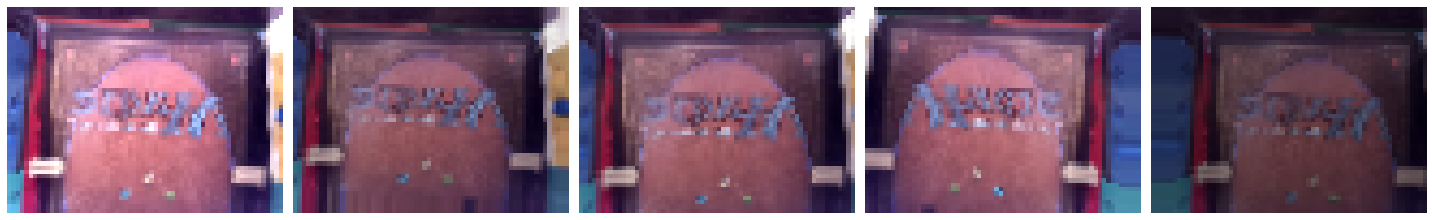

In [5]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Train Model

In [6]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=1,
    epochs=100,
    validation_data=val_data_gen,
    validation_steps=1,
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.7210 - accuracy: 0.5278 - val_loss: 0.6931 - val_accuracy: 0.4737
Epoch 2/100
1/1 [==============================] - 0s 380ms/step - loss: 0.6901 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.4737
Epoch 3/100
1/1 [==============================] - 0s 384ms/step - loss: 0.6912 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.4737
Epoch 4/100
1/1 [==============================] - 0s 378ms/step - loss: 0.6907 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.4737
Epoch 5/100
1/1 [==============================] - 0s 408ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6895 - val_accuracy: 0.4737
Epoch 6/100
1/1 [==============================] - 0s 378ms/step - loss: 0.6908 - accuracy: 0.5000 - val_loss: 0.6855 - val_accuracy

Epoch 56/100
1/1 [==============================] - 0s 381ms/step - loss: 0.5140 - accuracy: 0.9722 - val_loss: 0.4939 - val_accuracy: 1.0000
Epoch 57/100
1/1 [==============================] - 0s 399ms/step - loss: 0.5164 - accuracy: 0.9583 - val_loss: 0.4933 - val_accuracy: 1.0000
Epoch 58/100
1/1 [==============================] - 0s 416ms/step - loss: 0.5169 - accuracy: 0.9722 - val_loss: 0.4933 - val_accuracy: 1.0000
Epoch 59/100
1/1 [==============================] - 0s 405ms/step - loss: 0.5146 - accuracy: 0.9861 - val_loss: 0.4933 - val_accuracy: 1.0000
Epoch 60/100
1/1 [==============================] - 0s 398ms/step - loss: 0.5128 - accuracy: 0.9861 - val_loss: 0.4941 - val_accuracy: 1.0000
Epoch 61/100
1/1 [==============================] - 0s 392ms/step - loss: 0.5125 - accuracy: 0.9722 - val_loss: 0.4962 - val_accuracy: 1.0000
Epoch 62/100
1/1 [==============================] - 0s 383ms/step - loss: 0.5096 - accuracy: 0.9861 - val_loss: 0.4989 - val_accuracy: 1.0000
Epoch 

# Analysis

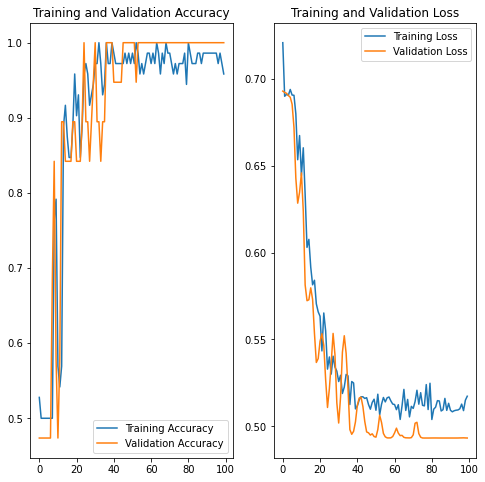

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Save Model

In [9]:
#model.save_weights('./back_front_v000') # only saves the weights, not the structure
model.save('mtg_back_front_classifier_v%03d' % VERSION)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mtg_back_front_classifier_v001/assets
